In [10]:
from ipywidgets import interact, interact_manual
from matplotlib import pyplot as plt
import cv2
import numpy as np


def load_image(source):
    try:
        image = cv2.imread(source)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    except Exception as e:
        print(f"could not load image, err: {e}")
        return None


def show_2_images(image1, image2, title1, title2):
    _, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image1, cmap='gray')
    ax[0].set_title(title1)

    ax[1].imshow(image2, cmap='gray')
    ax[1].set_title(title2)

    for a in ax:
        a.set_axis_off()

    plt.tight_layout()
    plt.show()


IMAGE_PATH = 'dataset/trim/IMG_2426.jpeg'
ORIGINAL_IMG = load_image(IMAGE_PATH)
PIPELINE_IMG = ORIGINAL_IMG

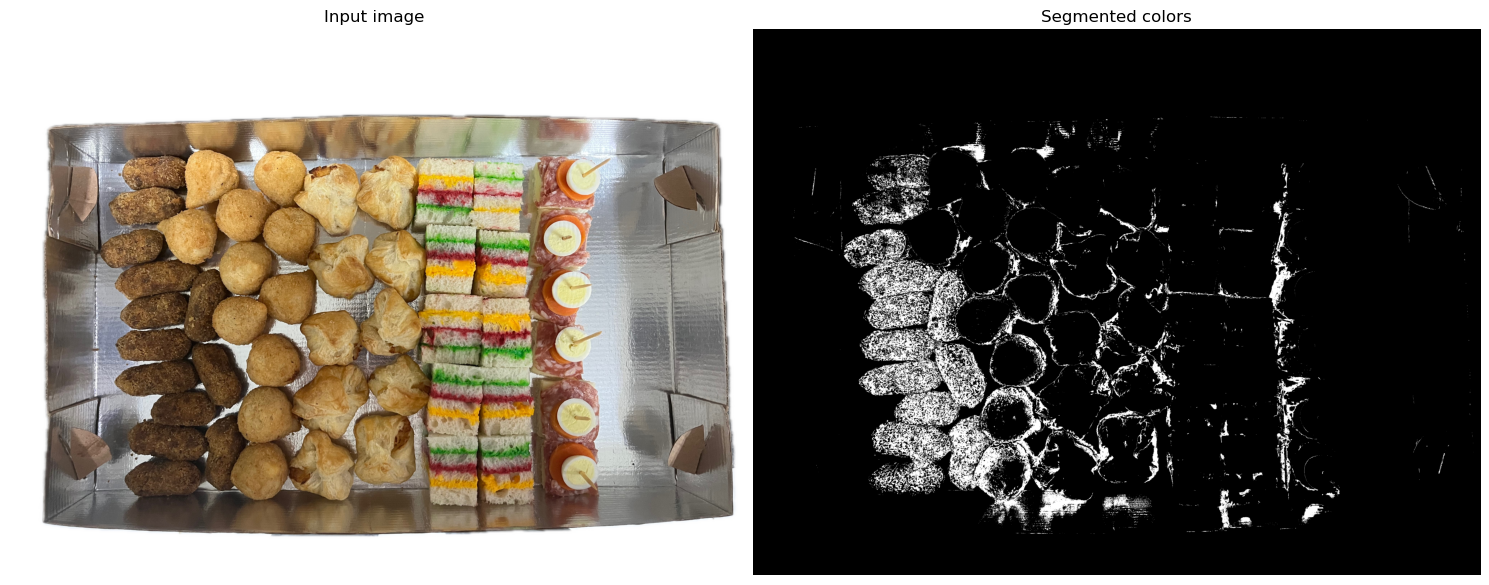

In [ ]:
# TODO:
# mahalanobis (sobre o marrom) -> abertura pra eliminar o que sobrou
# fechamento com kernel menor

def segment_by_color(image, lower_threshold, upper_threshold):
    global PIPELINE_IMG
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    PIPELINE_IMG = cv2.inRange(hsv_image, lower_threshold, upper_threshold)
    #PIPELINE_IMG = cv2.bitwise_and(PIPELINE_IMG, image, mask=mask)

    show_2_images(image, PIPELINE_IMG, 'Input image', 'Segmented colors')


lower_t = np.array([8, 130, 10])
upper_t = np.array([24, 180, 140])

segment_by_color(PIPELINE_IMG, lower_t, upper_t)

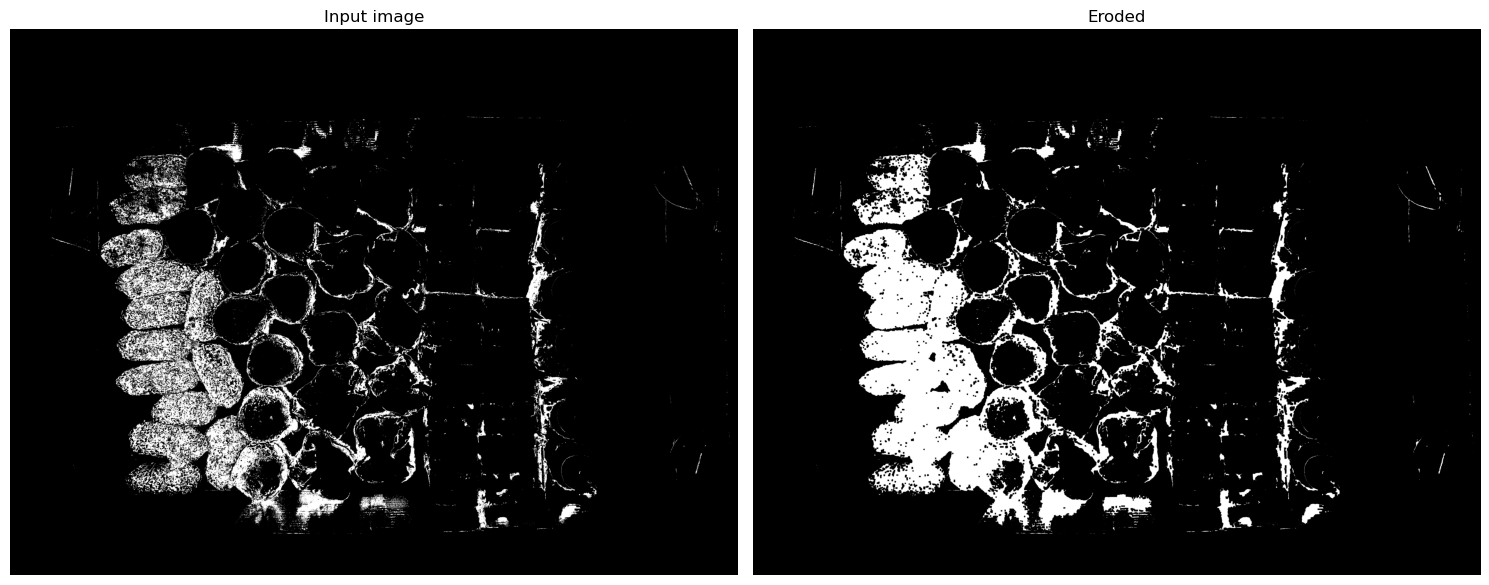

In [12]:
def apply_closing(image, kernel_size, iterations):
    global PIPELINE_IMG

    gray_image = PIPELINE_IMG
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    #PIPELINE_IMG = cv2.dilate(gray_image, kernel, iterations=iterations)
    #PIPELINE_IMG = cv2.erode(PIPELINE_IMG, kernel, iterations=iterations)
    PIPELINE_IMG = cv2.morphologyEx(gray_image, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    show_2_images(image, PIPELINE_IMG, 'Input image', 'Eroded')


apply_closing(image=PIPELINE_IMG, kernel_size=(7,7), iterations=1)

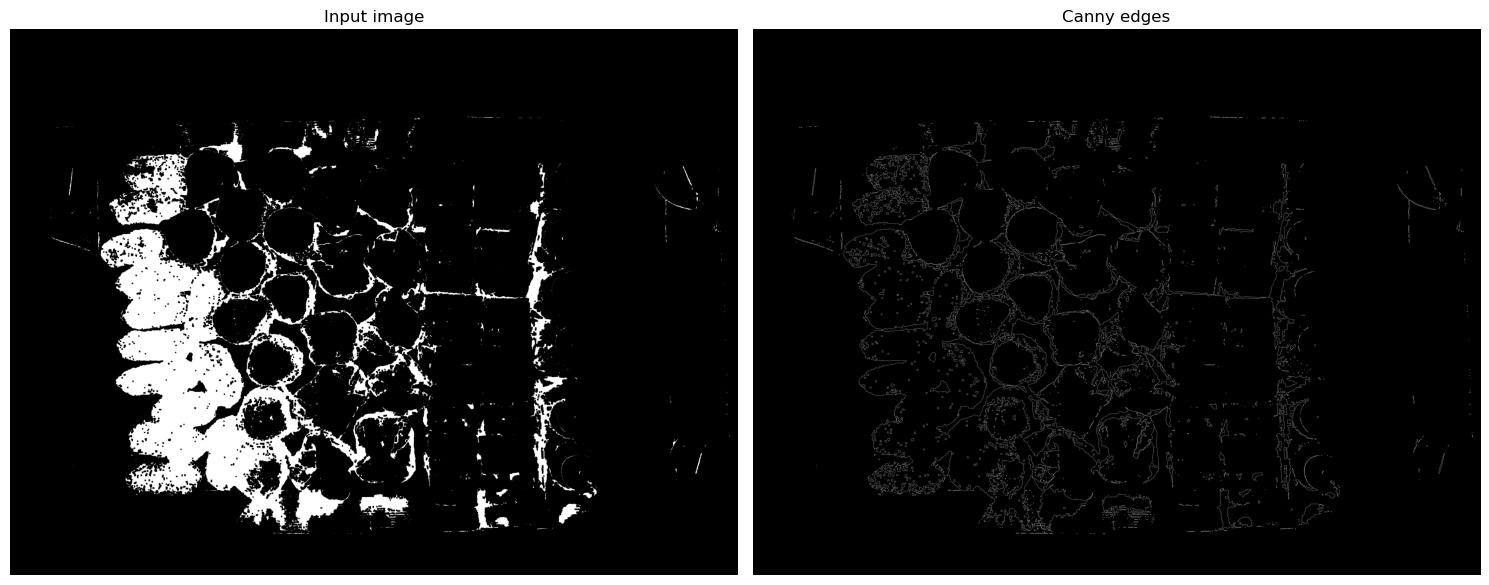

In [13]:
def apply_canny(image, threshold1, threshold2, apertureSize, L2gradient):
    global PIPELINE_IMG

    gray_image = PIPELINE_IMG
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    blurred_image = cv2.bilateralFilter(gray_image, 50, 90, 90)
    #blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    PIPELINE_IMG = cv2.Canny(blurred_image, threshold1=threshold1, threshold2=threshold2, apertureSize=apertureSize, L2gradient=L2gradient) 

    show_2_images(image, PIPELINE_IMG, 'Input image', 'Canny edges')


# NOTE: Original image best with gaussian blurred at 65/195 or bilaterealFilter at 15/45
#apply_canny(image=ORIGINAL_IMG, threshold1=15, threshold2=45, apertureSize=3, L2gradient=True)

apply_canny(image=PIPELINE_IMG, threshold1=15, threshold2=45, apertureSize=3, L2gradient=True)

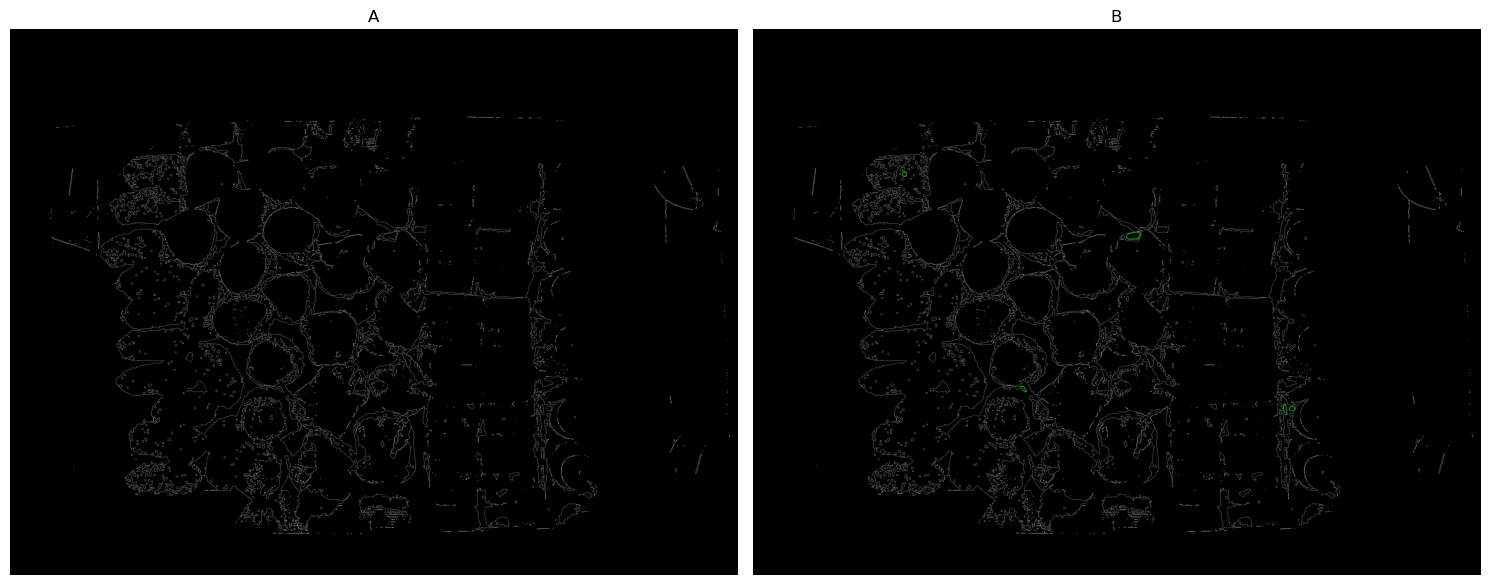

detected: 5


In [14]:
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter


def count_ellipses_hough(image, accuracy=20, threshold=120, min_size=10, max_size=120, top_n=20):
    global PIPELINE_IMG
    if image is None:
        return 0, None

    result = hough_ellipse(image, accuracy=accuracy, threshold=threshold,
                           min_size=min_size, max_size=max_size)
    if result.size == 0:
        return 0, image.copy()

    # result is a structured array; sort by accumulator and take top candidates
    result.sort(order='accumulator')
    best = result[-top_n:]

    count = 0
    for r in best:
        yc, xc, a, b = [int(round(x)) for x in (r['yc'], r['xc'], r['a'], r['b'])]
        orientation = r['orientation']
        if a <= 0 or b <= 0:
            continue
        
        rr, cc = ellipse_perimeter(yc, xc, a, b, orientation)
        # clamp coords and draw
        rr = np.clip(rr, 0, PIPELINE_IMG.shape[0]-1)
        cc = np.clip(cc, 0, PIPELINE_IMG.shape[1]-1)
        PIPELINE_IMG[rr, cc] = (0, 255, 0)
        count += 1

    show_2_images(image, PIPELINE_IMG, 'Input image', 'Hough ellipse')
    return count


def count_ellipses_contours(image, area_min=500, area_ratio_tol=0.9, axis_ratio_max=5.0):
    global PIPELINE_IMG
    if image is None:
        return 0, None

    _, th = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    out = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    #mask = np.zeros_like(image)
    
    count = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < area_min or len(cnt) < 5:
            continue
        
        ellipse = cv2.fitEllipse(cnt)
        (MA, ma) = ellipse[1]
        a = max(MA, ma) / 2.0
        b = min(MA, ma) / 2.0
        ellipse_area = np.pi * a * b
        if ellipse_area <= 0:
            continue
        
        area_ratio = area / ellipse_area
        axis_ratio = (MA / ma) if ma > 0 else 999
        
        if area_ratio >= area_ratio_tol and axis_ratio <= axis_ratio_max:
            cv2.ellipse(out, ellipse, (0,255,0), 2)
            #cv2.drawContours(mask, [cnt], -1, 255, -1)
            count += 1

    return count, out


# executed for 14min and nothing, too slow!
#count = count_ellipses_hough(PIPELINE_IMG)


count, out = count_ellipses_contours(PIPELINE_IMG)
show_2_images(PIPELINE_IMG, out, 'A', 'B')

print('detected:', count)

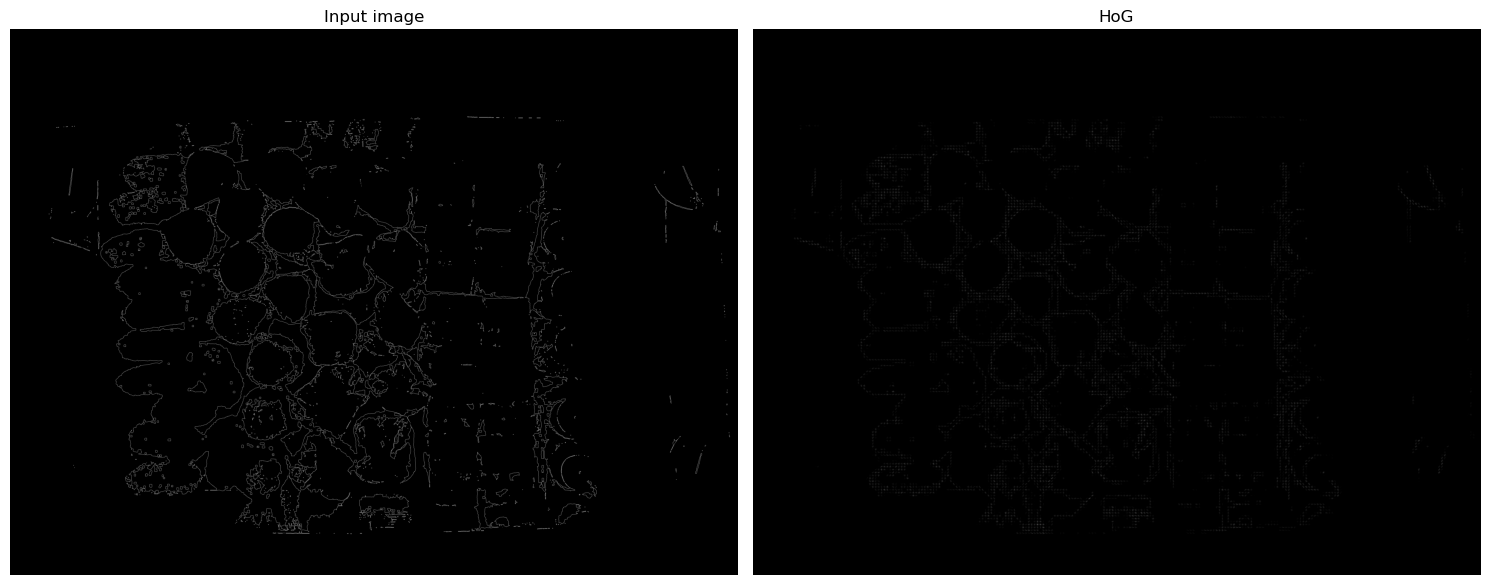

In [ ]:
from skimage.feature import hog


def apply_hog(image, cell_size):
    global PIPELINE_IMG

    gray_image = PIPELINE_IMG
    channel_axis = None
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        channel_axis = -1

    _, PIPELINE_IMG = hog(gray_image, orientations=8, pixels_per_cell=(cell_size, cell_size),
        cells_per_block=(1, 1), visualize=True, channel_axis=channel_axis)

    show_2_images(image, PIPELINE_IMG, 'Input image', 'HoG')


apply_hog(PIPELINE_IMG, 16)    

Passo prévio de remoção de fundo. Optei por utilizar images já editadas de /trim

TODO: Não deveria estar cinza?

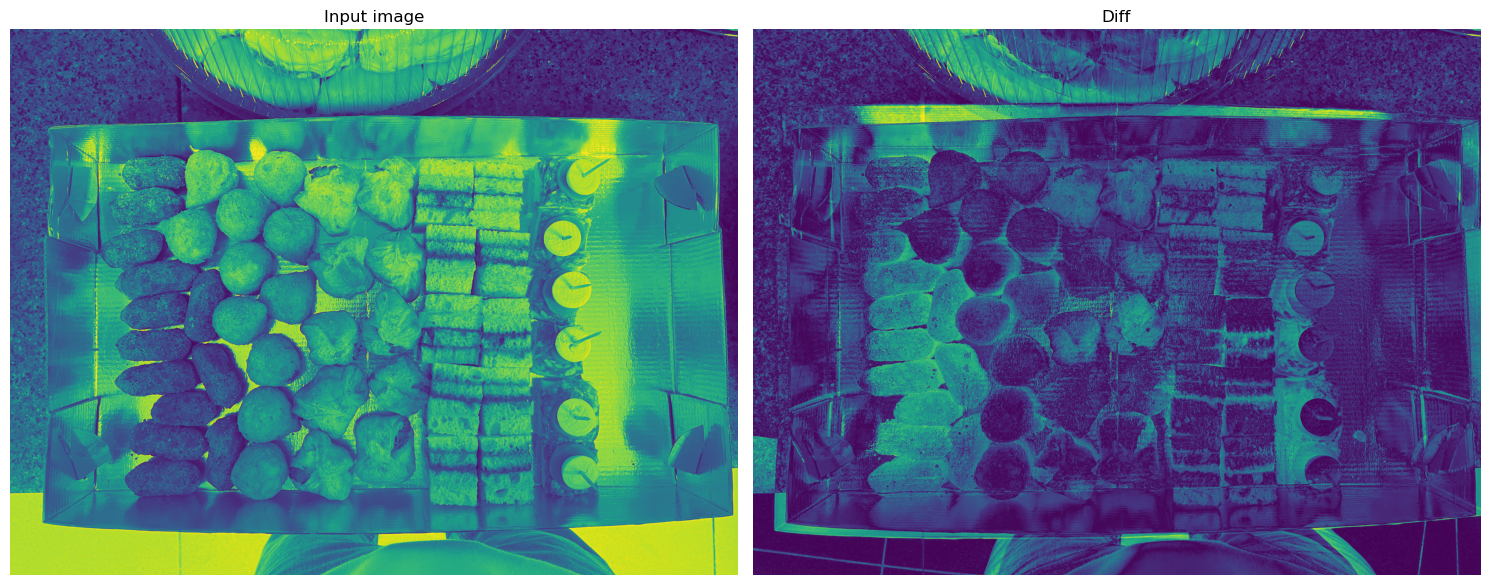

In [ ]:
def remove_background(source, ref_source):
    image = cv2.imread(source, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Could not load image.")
        return
    
    ref_image = cv2.imread(ref_source, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Could not load image.")
        return
    
    change = cv2.absdiff(image, ref_image)
    show_2_images(image, change, 'Input image', 'Diff')


remove_background('dataset/jpeg/IMG_2426.jpeg', 'dataset/jpeg/IMG_2455.jpeg')